## ASSIGNMENT-2
Roll Numbers:

Names:

### Instructions
 * Fill in the roll numbers and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.

## G2O Motion Model 

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive nodes k and k+1.

## PART 2

### 1. ICP Alignment with LieTorch (5 marks)
Resources: https://github.com/princeton-vl/lietorch/tree/master

Perform ICP Alignment of 2 PointClouds using LieTorch. Similar to what was expected in Part 1, you will be given a random Transformation matrix from the getTransform function. You are expected to transform the Toothless Point Cloud by this transformation, add noise to both sets of points (original and transformed) and estimate both, the Transformation matrix and the original point cloud.

Visualize your results using open3d

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3, LieGroupParameter
import torch
import torch.optim as optim

device = torch.device('cuda')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def getTransform():
    euler_angles = torch.rand(3) * 2 * torch.pi 
    translation = torch.rand(3) * 100
    transformation_param = torch.cat((translation,euler_angles)).cuda()
    return SE3.exp(transformation_param)

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    transformation_matrix = SE3_transform.matrix().to(device)
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    return transformed_points

def compute_loss(home_pcl, frame_pcl, transform):
    transformed = transform_point_cloud(home_pcl, transform)
    # transformed = transform.act(home_pcl)
    residual = frame_pcl - transformed
    loss = torch.norm(residual, dim=1).pow(2).mean()
    return loss

In [3]:
transform0 = getTransform()
transform1 = getTransform()

downsample = 0.8

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_tensor = torch.tensor(np.array(pcl.points), dtype=torch.float32, device=device)

pcl0 = transform_point_cloud(pcl_tensor + (torch.randn_like(pcl_tensor) * 2), transform0, downsample)
pcl0_tensor = pcl0.requires_grad_(True)
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.detach().cpu().numpy()))
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcl1 = transform_point_cloud(pcl_tensor + (torch.randn_like(pcl_tensor) * 0), transform1, downsample)
pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1.detach().cpu().numpy()))
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])
pcl1_tensor = pcl1.requires_grad_(True)

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
vis.add_geometry(pcl1_geom)
vis.poll_events()
vis.update_renderer()

# class Model(torch.nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         q = torch.randn(4).to(device)
#         q = q / q.norm()
#         t = torch.zeros(3).to(device)
#         self.vec = torch.nn.Parameter(torch.cat((t, q)))

#     def forward(self):
#         t = self.vec[:3]
#         q = self.vec[3:]
#         q = q / q.norm()
#         normalized_vec = torch.cat((t, q))
#         se3_transform = SE3.InitFromVec(normalized_vec)
#         return se3_transform

# class Model(torch.nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         # self.phi_translation = torch.nn.Parameter(torch.randn(1, 3, requires_grad=True).cuda())
#         # self.phi_rotation = torch.nn.Parameter(torch.randn(1, 3, requires_grad=True).cuda())
#         t = torch.randn(3).to(device)
#         ea = torch.randn(3).to(device)
#         self.vec = torch.nn.Parameter(torch.cat((t, ea)))

#     def forward(self):
#         t = self.vec[:3]
#         ea = self.vec[:3]
#         phi = torch.cat((t, ea))
#         se3 = SE3.exp(phi)
#         return se3


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        t = torch.randn(3).to(device)
        ea = torch.randn(3).to(device)
        self.vec = torch.nn.Parameter(ea)
        self.vec1 = torch.nn.Parameter(t)
        self.vec2 = torch.nn.Parameter(pcl0_tensor.clone())

    def forward(self):
        t = self.vec[:3]
        ea = self.vec1[:3]
        # t = torch.zeros(3).to(device)
        # ea = torch.zeros(3).to(device)
        phi = torch.cat((t, ea))
        se3 = SE3.exp(phi)
        denoised_points = self.vec2
        return se3,denoised_points
    
model = Model().to(device)
# optimizer = optim.SGD(model.parameters(), 1e-4)
# optimizer = optim.SGD(model.parameters(), 4e-0, momentum=0.9,weight_decay=0)
# optimizer = optim.SGD(model.parameters(), 5e-5, momentum=0.65, weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=0.1)
errors = []

for i in range(1000):
    optimizer.zero_grad()
    y_hat,newpcl = model()
    loss = compute_loss(newpcl,pcl1_tensor,y_hat)
    loss.backward()
    optimizer.step()
    pcl0_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(newpcl, y_hat).detach().cpu().numpy())
    # pcl0_geom.points = o3d.utility.Vector3dVector(y_hat.act(pcl0_tensor).detach().cpu().numpy())
    vis.update_geometry(pcl0_geom)
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    print(error)
    errors.append(error)

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RMSE Error')
plt.title('RMSE Error over Iterations')
plt.grid()
plt.show()

29662.533203125
28806.578125
27711.56640625
26396.79296875
24884.251953125
23200.8671875
21379.419921875
19458.83984375
17483.896484375
15504.3603515625
13573.47265625
11745.71875
10073.845703125
8605.09765625
7377.01171875
6413.1025390625
5719.314453125
5282.1904296875
5069.79296875
5035.67919921875
5125.353515625
5283.62841796875
5461.005859375
5617.85498046875
5726.0693359375
5768.76806640625
5738.8134765625
5636.9326171875
5469.82177734375
5248.4521484375
4986.59375
4699.48291015625
4402.619140625
4110.650390625
3836.3408203125
3589.732177734375
3377.51904296875
3202.743408203125
3064.863037109375
2960.168701171875
2882.531982421875
2824.351318359375
2777.583984375
2734.69580078125
2689.44873046875
2637.407470703125
2576.17919921875
2505.366455078125
2426.307373046875
2341.630126953125
2254.73876953125
2169.26416015625
2088.568115234375
2015.337646484375
1951.3218994140625
1897.2156982421875
1852.69970703125
1816.6009521484375
1787.1534423828125
1762.2972412109375
1739.978759765625

KeyboardInterrupt: 

In [4]:
vis.destroy_window()

### 2. ICP-SLAM with LieTorch (10 marks)

For this part, you will be given a set of `N` transformation matrices (Each relative to position 0). Add a random amount of noise to each of the `N` sets of points. Estimate the Transforms as well as the original point cloud using LieTorch.

Visualize your results using open3d

In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3, LieGroupParameter
import torch
import torch.optim as optim

In [ ]:
# def getTransforms():
#     # Output shape - (n, 4, 4)
#     pass

def getTransforms(N=5):
    euler_angles = torch.rand(N, 3) * 2 * torch.pi 
    translation = torch.rand(N, 3) * 500
    transformation_params = torch.cat((translation, euler_angles), dim=1).cuda()
    return SE3.exp(transformation_params)

getTransforms()

SE3: size=torch.Size([5]), device=cuda:0, dtype=torch.float32

Failed to converge


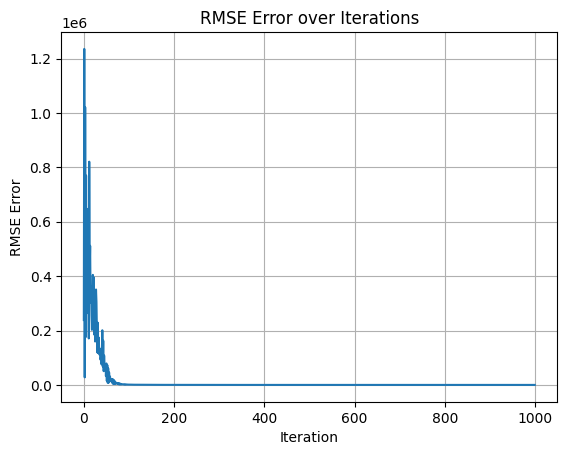

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Make sure to set the device
device = torch.device('cuda')

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    
    transformation_matrix = SE3_transform.matrix().to(device)
    
    if transformation_matrix.dim() == 2:
        # Single transformation
        rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
        transformed_points = rotated_points + transformation_matrix[:3, 3]
    elif transformation_matrix.dim() == 3:
        # Batch of transformations
        rotated_points = torch.matmul(point_cloud.unsqueeze(0), transformation_matrix[:, :3, :3].transpose(1, 2))
        transformed_points = rotated_points + transformation_matrix[:, :3, 3].unsqueeze(1)
    else:
        raise ValueError("Transformation matrix must be either 2D or 3D.")
    
    return transformed_points


# Compute loss between N transformed point clouds and the reference point cloud
def compute_loss(pcl0, pcls_transformed):
    residuals = pcls_transformed - pcl0.unsqueeze(0)
    loss = torch.norm(residuals, dim=-1).pow(2).mean()
    return loss

# Load point cloud and convert to tensor
pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_tensor = torch.tensor(np.array(pcl.points), dtype=torch.float32, device=device)

# Define the number of point clouds to be transformed
N = 5
downsample = 0.05

# Get transformations for N point clouds
transforms = getTransforms(N)

# Generate N noisy versions of the point cloud and transform them
pcl0 = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transforms[0], downsample)
pcl0_tensor = pcl0.requires_grad_(True)
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.detach().cpu().numpy()))
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcls_transformed = []
pcl_geoms = []

for i in range(N):
    pcl_i = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transforms[i], downsample)
    pcl_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl_i.detach().cpu().numpy()))
    pcl_geom.paint_uniform_color([0.0, 0.0, 1.0])
    pcl_geoms.append(pcl_geom)
    pcls_transformed.append(pcl_i)

pcls_transformed_tensor = torch.stack(pcls_transformed, dim=0).requires_grad_(True)

# Setup Open3D visualization
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
frame_torch = torch.tensor(np.array(frame0.vertices), dtype=torch.float32, device=device)
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
for pcl_geom in pcl_geoms:
    vis.add_geometry(pcl_geom)
vis.add_geometry(frame0)
vis.add_geometry(frame1)
vis.poll_events()
vis.update_renderer()

# Define the model for transforming N point clouds
class Model(torch.nn.Module):
    def __init__(self, N):
        super(Model, self).__init__()
        q = torch.randn(N, 4, device=device)
        q = q / q.norm(dim=1, keepdim=True)
        t = torch.randn(N, 3, device=device)
        self.vec = torch.nn.Parameter(torch.cat((t, q), dim=1))

    def forward(self, input):
        t = self.vec[:, :3]
        q = self.vec[:, 3:]
        q = q / q.norm(dim=1, keepdim=True)
        se3_transform = SE3.InitFromVec(self.vec)
        return transform_point_cloud(input, se3_transform)

model = Model(N).to(device)
optimizer = optim.SGD(model.parameters(), 4e-0, momentum=0.9, weight_decay=0)

errors = []

# Optimization loop
for i in range(1000):
    optimizer.zero_grad()
    y_hat = model(pcls_transformed_tensor)
    loss = compute_loss(pcl0_tensor, y_hat)
    loss.backward()
    optimizer.step()

    opti_transform = SE3.InitFromVec(model.vec)

    for j in range(N):
        pcl_geoms[j].points = o3d.utility.Vector3dVector(transform_point_cloud(pcls_transformed_tensor[j], opti_transform[j]).detach().cpu().numpy())
    pcl0_geom.points = o3d.utility.Vector3dVector(pcl0_tensor.detach().cpu().numpy())
    frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(frame_torch, opti_transform[0]).detach().cpu().numpy())
    vis.update_geometry(pcl0_geom)
    for pcl_geom in pcl_geoms:
        vis.update_geometry(pcl_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    # print(error)
    errors.append(error)
    
    if error < 3e0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        for pcl_geom in pcl_geoms:
            pcl_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        for pcl_geom in pcl_geoms:
            vis.update_geometry(pcl_geom)
        print(f"Converged in {i} iterations with {error:.4f} error.")
        break

if error > 3e0:
    print("Failed to converge")

vis.run()
vis.destroy_window()

# Plot errors
plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RMSE Error')
plt.title('RMSE Error over Iterations')
plt.grid()
plt.show()


In [ ]:
vis.destroy_window()